# PeakSwift: Analysis of Accuracy through Comparison towards Neurokit

This notebook presents an analysis of the PeakSwift package's capabilities in detecting R-peaks and assessment of signal quality within single-lead electrocardiogram signals. The evaluation is conducted against the established gold standard, NeuroKit. The analysis encompasses the thorough assessment and validation of the following key aspects:

- Accuracy of R-peak detection
- Performance in signal quality assessment
- Computational runtime efficiency

Through this analysis, we aim to provide a deeper understanding of the PeakSwift package's utility and effectiveness in comparison to a recognized standard. Additionally, the computational runtime is scrutinized to gauge the efficiency of the package in real-world applications.

In [1]:
import glob
import json
import time
from tqdm import tqdm
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import neurokit2 as nk
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
import session_info
session_info.show()

### Data Loading

The JSON-formatted exported data from the PeakWatch demo application must be located within the './data' directory.

In [3]:
def load_data(path="./data/*.json"):
    files = glob.glob(path)
    df = pd.DataFrame()
    events = pd.DataFrame()
    for k in files:
        f = json.load(open(k))
        df = pd.concat([df, pd.json_normalize(f['ecgs'])])
    df = df.reset_index()
    return df

Every row within the dataset corresponds to a 30-second electrocardiogram (ECG) recording, indicated in the 'ecg.ecg' column. Accompanying this primary data are essential metadata, including bpm, sampling rate, and date of recording. Additionally, PeakSwift's computed properties are included:

- R-peaks, computed through eight distinct detection algorithms
- Signal quality assessment, performed by two distinct algorithms

In [4]:
df = load_data()
df_os = load_data("./data/open-source/*.json")

In [5]:
df.head(1)

,index,signal_quality,algorithms,device_id,apple_meta_data.recording_start_time,apple_meta_data.recording_endt_ime,apple_meta_data.beats_per_minute,apple_meta_data.software_version,apple_meta_data.hardware_version,apple_meta_data.source,apple_meta_data.device_name,apple_meta_data.manufacturer,apple_meta_data.algorithm_version,apple_meta_data.added_to_health_kit_date,apple_meta_data.model,apple_meta_data.apple_rating,ecg.ecg,ecg.sampling_rate
0,0,"[{'score': 'unacceptable', 'method': 'Zhao2018...","[{'r_peaks': [], 'runtime': {'seconds': 0, 'at...",FF6DFD06-685C-4F56-95E6-46ED96109F6F,7.144910e+08,7.144910e+08,84,9.6.1,"Watch6,2",ECG,Apple Watch,Apple Inc.,2.0,7.144910e+08,Watch,Sinus rhytm,"[2.1156566619873046e-05, 2.0884790420532227e-0...",512.0


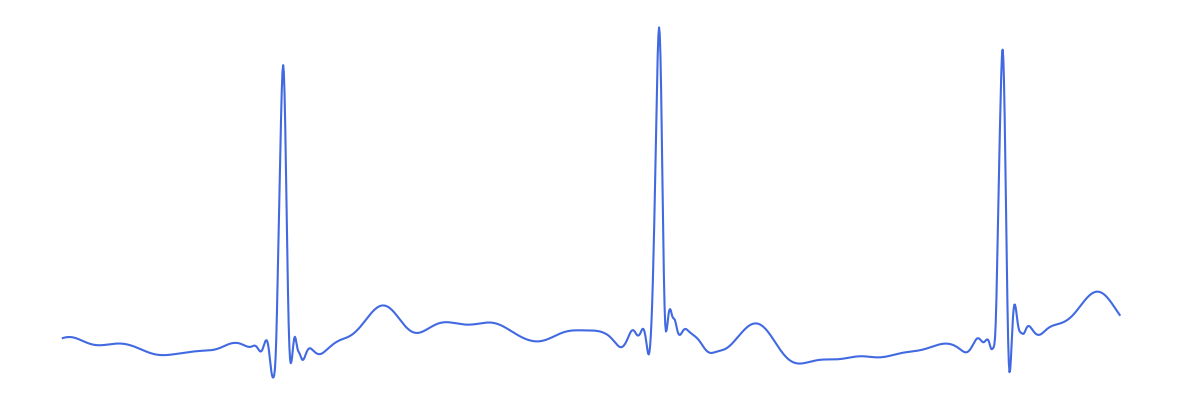

In [6]:
plt.figure(figsize=(15, 5))
plt.plot(df['ecg.ecg'][43][2000:3536], c='royalblue')
plt.axis('off')
plt.savefig('./results/sample_ecg.png', bbox_inches='tight', dpi=300)
#plt.close()

In [7]:
# Watch6,2 : Apple Watch Series 6 44mm case (GPS)
# Watch6,1 : Apple Watch Series 6 40mm case (GPS)
# Watch5,2 : Apple Watch Series 5 44mm case (GPS)

print('Watch Model:', df['apple_meta_data.hardware_version'].unique())

df['timestamp_recording'] = pd.to_datetime(df['apple_meta_data.recording_start_time'] + 978307200, unit='s')
df['subject'] = pd.factorize(df['device_id'])[0]

Watch Model: ['Watch6,2' 'Watch6,1' 'Watch5,2']


In [8]:
print('Total amount of self-recorded ECG:', len(df))
print('Total amount of open-source ECG:', len(df_os))

Total amount of self-recorded ECG: 509
Total amount of open-source ECG: 10646


In [9]:
df.groupby('subject')['subject'].count()

subject
0     50
1    240
2     16
3    203
Name: subject, dtype: int64

/var/folders/tb/_5frmyz16hz24t5gwc56dzmr0000gn/T/ipykernel_69965/2499197063.py:4: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.histplot(data=df, x="timestamp_recording", hue="subject", bins=100, palette=palette)


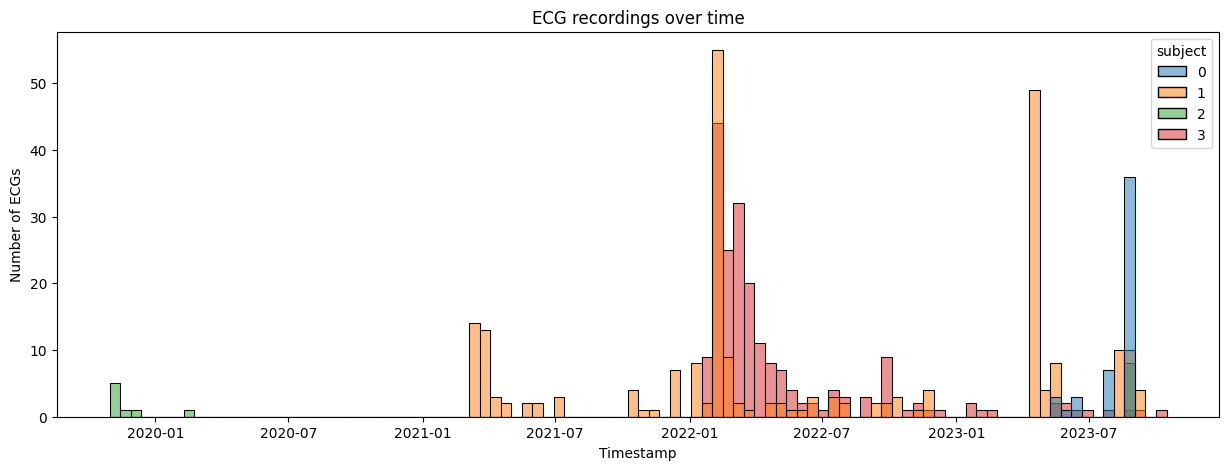

In [10]:
palette = sns.color_palette('tab10')
fig = plt.figure(figsize=(15,5))
plt.set_cmap('tab10')
ax = sns.histplot(data=df, x="timestamp_recording", hue="subject", bins=100, palette=palette)
ax.set(xlabel='Timestamp', ylabel='Number of ECGs')
ax.set_title('ECG recordings over time')
plt.show()
fig.savefig('./results/recordings.png', bbox_inches='tight', dpi=300)
plt.close()

### Functions and Tools for Evaluation

Mapping from PeakSwift's to NeuroKit's Algorithm Naming Convention

In [11]:
algorithm_conversion_peak = {
    'Christov': 'christov',
    'Two Average': 'elgendi',
    'NeuroKit': 'neurokit',
    'Hamilton': 'hamilton',
    'Pan Tompkins': 'pantompkins',
    'Kalidas': 'kalidas',
    'Engzee': 'engzee',
    'Nabian': 'nabian',
    'Basic': None,
    'Aristotle': None,
    'WQRS': None,
    'UNSW': None,
}

algorithm_conversion_clean = {
    'christov': 'christov',
    'elgendi': 'elgendi2010',
    'neurokit': 'neurokit',
    'hamilton': 'hamilton2002',
    'pantompkins': 'pantompkins1985',
    'engzee': 'engzeemod2012',
    'kalidas': 'kalidas',
    'nabian': 'nabian',
    'Basic': None,
    'Aristotle': None,
    'UNSW': None,
    'WQRS': None,
}

In [12]:
def mean_std(series):
    return str(np.round(np.mean(series),5)) + '$\pm$' + str(np.round(np.std(series),5))

def closest_value(arr, value):
    """
    Find the value in an array 'arr' that is closest to the given 'value'.
    """
    return arr[np.argmin(np.abs(arr - value))]

def mapped_mae(arr1, arr2, threshold_low=0, threshold_up=1000000000):
    """
    Calculate the mapped Mean Absolute Error (MAE) between two arrays 'arr1' and 'arr2',
    with optional lower and upper thresholds for error calculation.
    """
    total_mae = 0
    
    shorter_arr = arr1 if len(arr1) < len(arr2) else arr2
    longer_arr = arr2 if len(arr1) < len(arr2) else arr1
    
    for val1 in shorter_arr:
        closest_val2 = closest_value(longer_arr, val1)
        abs_diff = np.abs(val1 - closest_val2)
        if threshold_low <= abs_diff <= threshold_up:
            total_mae += abs_diff
    
    if len(shorter_arr) == 0:
        return 0
    
    return total_mae / len(shorter_arr)

def mae(arr1, arr2, threshold_low=0, threshold_up=100000000000):
    """
    Calculate the Mean Absolute Error (MAE) between two arrays 'arr1' and 'arr2',
    with optional lower and upper thresholds for error calculation.
    """
    abs_diffs = np.abs(arr1 - arr2)
    abs_diffs[(abs_diffs <= threshold_low) | (abs_diffs >= threshold_up)] = 0
    return np.mean(abs_diffs)

                

In [13]:
def evaluate_rPeaks(rPeaksDetected, rPeaksComparision):
    true_positive = []
    false_positive = []
    false_negative = []
    
    for rPeakDetected in rPeaksDetected:
        if rPeakDetected in rPeaksComparision:
            true_positive.append(rPeakDetected)
        else:
            false_positive.append(rPeakDetected)
            
    for rPeak in rPeaksComparision:
        if not rPeak in true_positive:
            false_negative.append(rPeak)
            
    return {
        'tp': true_positive,
        'fp': false_positive,
        'fn': false_negative
    }

In [14]:
def compare_algorithm(signal, method, result_swift, sampling_rate=512, index=None, plot=False):
    
    """
    Compare R-peak detection algorithms and visualize the results.

    Parameters:
    signal (array-like): ECG signal.
    method (str, optional): R-peak detection method (default: 'neurokit').
    result_swift (array-like): Detected R-peaks from Swift algorithm.
    sampling_rate (int, optional): Sampling rate of the signal (default: 512).
    index (int): Index of the signal.
    plot (bool): Whether to plot the comparison.

    Returns:
    dict: Dictionary containing comparison results.
    """

    start = time.time()
    if method != 'nabian':
        cleaned_signal = nk.ecg_clean(signal, sampling_rate, method=algorithm_conversion_clean[method])
    else:
        cleaned_signal = signal
    end = time.time()
    time_cleaning = (end - start)

    start = time.time()
    
    result_nk = nk.ecg_peaks(cleaned_signal, sampling_rate, method)
    end = time.time()
    time_rPeak_detection = (end - start)
    result_nk = np.where(result_nk[0]['ECG_R_Peaks'] > 0)[0]
    
    number_r_peaks_swift = len(result_swift)
    number_r_peaks_neurokit = len(result_nk)
    
    # Plot dedicated sample for the publication
    if (index == 118) & (method=='engzee'):
        n_peaks = 512*4
        signal = 10000*signal
        plt.figure(figsize=(15, 5))
        plt.plot(signal[0:n_peaks], c='red', label='Original Signal')
        a = np.array(result_swift)
        b = np.array(result_nk)
        a = a[a <= n_peaks]
        b = b[b <= n_peaks]
        plt.vlines(
            x=a, colors='blue',
            ymin=0.0, ymax=np.max(signal),
            label='Swift: Detected ' + str(len(a)) +  ' R-peaks with ' + method,
        )
        plt.vlines(
            x=b, colors='green',
            ymin=np.min(signal), ymax=0.0,
            label='Python: Detected ' + str(len(b)) + ' R-peaks with ' + method,
        )
        plt.xlabel('Timestamp')
        plt.ylabel('Amplitude')
        plt.title('Comparison of R-peak Detection')
        plt.legend()
        plot_filename = f'./results/publication_sample_{index}_{method}.png'
        plt.savefig(plot_filename, bbox_inches='tight', dpi=300)
        plt.close()
    
    if plot & (number_r_peaks_swift !=number_r_peaks_neurokit):
        plt.figure(figsize=(60, 5))
        plt.plot(signal, c='red', label='Original Signal')
        plt.vlines(
            x=result_swift, colors='blue',
            ymin=np.min(signal), ymax=np.max(signal),
            label='Swift: Detected ' + str(len(result_swift)) +  ' R-peaks with ' + method,
        )
        plt.vlines(
            x=result_nk, colors='green',
            ymin=np.min(signal), ymax=np.max(signal),
            label='Python: Detected ' + str(len(result_nk)) + ' R-peaks with ' + method,
        )
        plt.xlabel('Sample')
        plt.ylabel('Amplitude')
        plt.title('Comparison of R-peak Detection')
        plt.legend()
        plot_filename = f'./results/{index}_{method}.png'
        plt.savefig(plot_filename, bbox_inches='tight', dpi=300)
        plt.close()
    
    if (number_r_peaks_swift == number_r_peaks_neurokit):
        mean_difference_t0 = mae(result_nk, result_swift)
        mean_difference_t1 = mae(result_nk, result_swift, 1)
        mean_difference_t5 = mae(result_nk, result_swift, 5)
        mean_difference_t10 = mae(result_nk, result_swift, 200)
    else:
        mean_difference_t0 = np.nan
        mean_difference_t1 = np.nan
        mean_difference_t5 = np.nan
        mean_difference_t10 = np.nan

    mean_difference_mapped_t0 = mapped_mae(result_nk, result_swift)
    mean_difference_mapped_t1 = mapped_mae(result_nk, result_swift, 1)
    mean_difference_mapped_t5 = mapped_mae(result_nk, result_swift, 5)
    mean_difference_mapped_t10 = mapped_mae(result_nk, result_swift, 10)
    
    scores = evaluate_rPeaks(result_swift, result_nk)
    
    result = {
        'mean_difference_t0': mean_difference_t0,
        'mean_difference_t1': mean_difference_t1,
        'mean_difference_t5': mean_difference_t5,
        'mean_difference_t10': mean_difference_t10,
        'mean_difference_mapped_t0': mean_difference_mapped_t0,
        'mean_difference_mapped_t1': mean_difference_mapped_t1,
        'mean_difference_mapped_t5': mean_difference_mapped_t5,
        'mean_difference_mapped_t10': mean_difference_mapped_t10,
        'bpm_swift_simple': number_r_peaks_swift * 2,
        'bpm_swift_rr': (60*sampling_rate) / np.mean(np.diff(result_swift)),
        'number_r_peaks_swift': number_r_peaks_swift,
        'number_r_peaks_neurokit': number_r_peaks_neurokit,
        'runtime_m1_cleaning': time_cleaning,
        'runtime_m1_rPeak_detection': time_rPeak_detection,
        'tp': len(scores['tp']),
        'fp': len(scores['fp']),
        'fn': len(scores['fn'])
    }
    
    return result

In [15]:
def process_row(row, algorithm_conversion_peak, index, plot=False, non_apple_source=False):
    signal = np.array(row['ecg.ecg'])
    sampling_rate = row['ecg.sampling_rate']
    
    quality_neurokit_simple = np.nan
    quality_peakswift_simple = np.nan
    quality_neurokit_fuzzy = np.nan
    quality_peakswift_fuzzy = np.nan
    
    for quality in row.signal_quality:
        if quality['method'] == 'Zhao2018Simple':
            quality_neurokit_simple = nk.ecg_quality(signal, method='zhao2018', approach='simple', sampling_rate=sampling_rate)
            quality_peakswift_simple = quality['score']
        elif quality['method'] == 'Zhao2018Fuzzy':
            quality_neurokit_fuzzy = nk.ecg_quality(signal, method='zhao2018', approach='fuzzy', sampling_rate=sampling_rate)
            quality_peakswift_fuzzy = quality['score']
        else:
            print('sth went wrong')
    
    result_rows = []
    
    identifier = row['device_id']
    
    if non_apple_source:
        bpm_apple = None
        device = None
        subject = None
        quality_apple = None
    else:
        bpm_apple = row['apple_meta_data.beats_per_minute']
        device = row['apple_meta_data.hardware_version']
        subject = row['subject']
        quality_apple = row['apple_meta_data.apple_rating']
        
    for algo_info in row.algorithms:
        algo_name = algo_info['algorithm']
        algorithm = algorithm_conversion_peak.get(algo_name)
        
        if algorithm is None:
            continue
        
        try:
            comparison = compare_algorithm(signal, algorithm, algo_info['r_peaks'], sampling_rate, index, plot)
        except Exception as error:
            print('Exception', identifier, algorithm, error)
            continue

        metadata = {
            'id': index,
            'subject': subject,
            'device': device,
            'sampling_rate': sampling_rate,
            'signal_quality_neurokit_simple': quality_neurokit_simple,
            'signal_quality_neurokit_fuzzy': quality_neurokit_fuzzy,
            'signal_quality_swift_simple': quality_peakswift_simple,
            'signal_quality_swift_fuzzy': quality_peakswift_fuzzy,
            'signal_rating_apple': quality_apple,
            'algorithm': algorithm,
            'bpm_apple': bpm_apple,
            'runtime_swift': algo_info['runtime']['seconds'] + algo_info['runtime']['attoseconds'] / 1e+18,
        }

        result_rows.append({**metadata, **comparison})

    return result_rows

Loop through the dataframe and construct a result table by gathering benchmarking metrics.

In [16]:
def get_results_table(df, signal_length, algorithm_conversion_peak, non_apple_source=False, plot=False, real_time_thres=0.01):
    result_rows = []
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        try:
            result_rows.extend(process_row(row, algorithm_conversion_peak, index, plot, non_apple_source))
        except Exception as e:
            print('Failed for index', index, 'with error:', e)
        
    result_table = pd.DataFrame(result_rows)
    result_table.index = range(len(result_table))
    
    result_table['bpm_difference_simple'] = np.abs(result_table['bpm_apple'] - result_table['bpm_swift_simple'])
    result_table['bpm_difference_rr'] = np.abs(result_table['bpm_apple'] - result_table['bpm_swift_rr'])
    result_table['peak_diff'] = np.abs(result_table['number_r_peaks_neurokit'] - result_table['number_r_peaks_swift'])

    runtime_m1_total = result_table['runtime_m1_cleaning'] + result_table['runtime_m1_rPeak_detection']
    result_table['runtime_swift'] = result_table['runtime_swift'] * 1000 # ms instead of s
    result_table['runtime_neurokit'] = runtime_m1_total * 1000 # ms instead of s
    result_table['runtime_difference'] = result_table['runtime_neurokit'] - result_table['runtime_swift']
    result_table['swift_faster'] = result_table['runtime_neurokit'] / result_table['runtime_swift']

    result_table['real_time_capabilities'] = result_table.runtime_swift / signal_length
    result_table['real_time_capabilities_bool'] = result_table.real_time_capabilities < real_time_thres
    
    return result_table

In [17]:
result_table = get_results_table(df, 30000.0, algorithm_conversion_peak)

 12%|██████████████▏                                                                                                           | 59/509 [00:11<01:29,  5.02it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 29%|██████████████████████████████████▉                                                                                      | 147/509 [00:29<01:13,  4.94it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 38%|█████████████████████████████████████████████▍                                                                           | 191/509 [00:38<01:03,  5.01it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 63%|████████████████████████████████████████████████████████████████████████████▌                                            | 322/509 [01:05<00:38,  4.84it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 443/509 [01:30<00:13,  5.02it/s]

Exception 4AA362E7-E144-4221-B76F-0EB80FFA3DDF engzee pop from empty list


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 509/509 [01:43<00:00,  4.92it/s]


In [18]:
result_table_os = get_results_table(df_os, 10000.0, algorithm_conversion_peak, non_apple_source=True)

  0%|                                                                                                                         | 1/10646 [00:00<19:23,  9.15it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  0%|▏                                                                                                                       | 15/10646 [00:01<12:27, 14.23it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Failed for index 22 with error: index 0 is out of bounds for axis 0 with size 0


  0%|▎                                                                                                                       | 26/10646 [00:01<11:18, 15.66it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  0%|▍                                                                                                                       | 36/10646 [00:02<12:09, 14.55it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Failed for index 90 with error: index 0 is out of bounds for axis 0 with size 0


  1%|█▋                                                                                                                     | 155/10646 [00:11<11:59, 14.58it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  2%|██                                                                                                                     | 179/10646 [00:12<12:04, 14.45it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Failed for index 238 with error: index 0 is out of bounds for axis 0 with size 0


  2%|██▊                                                                                                                    | 252/10646 [00:17<11:48, 14.68it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  2%|██▉                                                                                                                    | 258/10646 [00:18<11:55, 14.51it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


  3%|███                                                                                                                    | 278/10646 [00:19<12:07, 14.26it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


  3%|███▏                                                                                                                   | 286/10646 [00:20<12:36, 13.70it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


  3%|███▎                                                                                                                   | 298/10646 [00:21<12:00, 14.37it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  3%|███▌                                                                                                                   | 318/10646 [00:22<11:49, 14.56it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


  3%|███▊                                                                                                                   | 343/10646 [00:24<10:24, 16.49it/s]

Failed for index 341 with error: index 0 is out of bounds for axis 0 with size 0


  4%|████▏                                                                                                                  | 373/10646 [00:26<11:54, 14.39it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  4%|████▏                                                                                                                  | 375/10646 [00:26<11:50, 14.45it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Failed for index 440 with error: index 0 is out of bounds for axis 0 with size 0


  4%|█████                                                                                                                  | 448/10646 [00:31<11:17, 15.04it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  4%|█████▏                                                                                                                 | 460/10646 [00:32<11:49, 14.35it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


  4%|█████▎                                                                                                                 | 470/10646 [00:32<11:50, 14.33it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  5%|█████▍                                                                                                                 | 484/10646 [00:33<11:44, 14.43it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


  5%|██████▎                                                                                                                | 563/10646 [00:39<10:09, 16.54it/s]

Failed for index 561 with error: index 0 is out of bounds for axis 0 with size 0


  5%|██████▎                                                                                                                | 565/10646 [00:39<10:26, 16.09it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  6%|██████▊                                                                                                                | 609/10646 [00:42<11:29, 14.55it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Failed for index 691 with error: index 0 is out of bounds for axis 0 with size 0


  7%|████████▍                                                                                                              | 752/10646 [00:52<11:26, 14.40it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


  7%|████████▉                                                                                                              | 796/10646 [00:55<12:14, 13.42it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  8%|█████████▏                                                                                                             | 822/10646 [00:57<11:54, 13.75it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


  8%|█████████▉                                                                                                             | 886/10646 [01:02<11:13, 14.50it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  8%|█████████▉                                                                                                             | 894/10646 [01:02<11:13, 14.47it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


  8%|██████████                                                                                                             | 900/10646 [01:02<11:12, 14.48it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  9%|██████████▍                                                                                                            | 939/10646 [01:05<09:45, 16.59it/s]

Failed for index 937 with error: index 0 is out of bounds for axis 0 with size 0


  9%|██████████▋                                                                                                            | 954/10646 [01:06<09:37, 16.78it/s]

Failed for index 951 with error: index 0 is out of bounds for axis 0 with size 0


  9%|██████████▊                                                                                                            | 968/10646 [01:07<11:05, 14.53it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list
Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


  9%|██████████▊                                                                                                            | 970/10646 [01:07<11:06, 14.52it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  9%|██████████▊                                                                                                            | 972/10646 [01:07<11:09, 14.44it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 10%|███████████▍                                                                                                          | 1031/10646 [01:11<09:37, 16.64it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Failed for index 1028 with error: index 0 is out of bounds for axis 0 with size 0


/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 10%|███████████▌                                                                                                          | 1041/10646 [01:12<11:13, 14.25it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 10%|███████████▋                                                                                                          | 1057/10646 [01:13<11:05, 14.40it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 10%|███████████▋                                                                                                          | 1059/10646 [01:13<11:09, 14.32it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list
Failed for index 1099 with error: index 0 is out of bounds for axis 0 with size 0


/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 11%|████████████▍                                                                                                         | 1124/10646 [01:18<10:55, 14.54it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 11%|████████████▋                                                                                                         | 1140/10

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 11%|████████████▉                                                                                                         | 1168/10646 [01:21<10:51, 14.55it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 11%|█████████████                                                                                                         | 1177/10646 [01:22<10:36, 14.87it/s]

Failed for index 1175 with error: index 0 is out of bounds for axis 0 with size 0


 11%|█████████████                                                                                                         | 1181/10646 [01:22<10:44, 14.70it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 11%|█████████████▏                                                                                                        | 1189/10646 [01:22<10:53, 14.48it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Failed for index 1213 with error: index 0 is out of bounds for axis 0 with size 0


 12%|█████████████▊                                                                                                        | 1250/10646 [01:27<10:44, 14.58it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 12%|█████████████▉                                                                                                        | 1258/10646 [01:27<10:40, 14.66it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 12%|█████████████▉                                                                                                        | 1260/10646 [01:27<10:42, 14.60it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scal

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 12%|██████████████▎                                                                                                       | 1290/10646 [01:29<10:47, 14.45it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 12%|██████████████▌                                                                                                       | 1310/10646 [01:31<10:35, 14.70it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 13%|██████████████▉                                                                                                       | 1346/10646 [01:33<11:37, 13.32it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 13%|███████████████▋                                                                                                      | 1418/10646 [01:38<10:37, 14.48it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 13%|███████████████▋                                                                                                      | 1420/10646 [01:38<10:37, 14.47it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 14%|████████████████▍                                                                                                     | 1478/10646 [01:42<10:34, 14.45it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 14%|████████████████▍                                                                                                     | 1484/10646 [01:43<10:35, 14.43it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 14%|████████████████▋                                                                                                     | 1501/10646 [01:44<09:06, 16.73it/s]

Failed for index 1498 with error: index 0 is out of bounds for axis 0 with size 0


 14%|████████████████▋                                                                                                     | 1503/10646 [01:44<09:31, 15.99it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 15%|█████████████████▎                                                                                                    | 1563/10646 [01:48<10:30, 14.40it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 15%|█████████████████▉                                                                                                    | 1614/10646 [01:52<08:58, 16.77it/s]

Failed for index 1612 with error: index 0 is out of bounds for axis 0 with size 0


 15%|█████████████████▉                                                                                                    | 1618/10646 [01:52<09:42, 15.51it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 15%|██████████████████                                                                                                    | 1634/10646 [01:53<10:15, 14.63it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 16%|██████████████████▍                                                                                                   | 1669/10646 [01:55<09:05, 16.46it/s]

Failed for index 1666 with error: index 0 is out of bounds for axis 0 with size 0


 16%|██████████████████▌                                                                                                   | 1677/10646 [01:56<09:57, 15.01it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 16%|██████████████████▌                                                                                                   | 1679/10646 [01:56<10:03, 14.86it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 16%|██████████████████▋                                                                                                   | 1687/10646 [01:57<10:14, 14.58it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 16%|██████████████████▋                                                                                                   | 1689/10646 [01:57<10:15, 14.55it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 16%|██████████████████▉                                                                                                   | 1709/10646 [01:58<10:18, 14.45it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 16%|███████████████████                                                                                                   | 1717/10646 [01:59<10:15, 14.51it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Failed for index 1754 with error: index 0 is out of bounds for axis 0 with size 0


 17%|███████████████████▌                                                                                                  | 1766/10646 [02:02<09:57, 14.85it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 17%|███████████████████▊                                                                                                  | 1784/10646 [02:03<10:16, 14.36it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Failed for index 1792 with error: index 0 is out of bounds for axis 0 with size 0


 17%|████████████████████▏                                                                                                 | 1817/10646 [02:05<10:03, 14.64it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 17%|████████████████████▏                                                                                                 | 1823/10646 [02:06<10:14, 14.37it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Failed for index 1824 with error: index 0 is out of bounds for axis 0 with size 0


 17%|████████████████████▎                                                                                                 | 1838/10646 [02:07<10:03, 14.60it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 17%|████████████████████▌                                                                                                 | 1850/10646 [02:08<10:06, 14.50it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 18%|████████████████████▋                                                                                                 | 1868/10646 [02:09<10:11, 14.35it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 18%|████████████████████▊                                                                                                 | 1874/10646 [02:09<10:12, 14.31it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 18%|████████████████████▊                                                                                                 | 1880/10

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 18%|█████████████████████▏                                                                                                | 1908/10646 [02:12<10:05, 14.43it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 18%|█████████████████████▌                                                                                                | 1940/10646 [02:14<10:03, 14.44it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Failed for index 1970 with error: index 0 is out of bounds for axis 0 with size 0


 19%|██████████████████████▏                                                                                               | 2003/10646 [02:18<09:50, 14.63it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 19%|██████████████████████▎                                                                                               | 2011/10646 [02:19<09:56, 14.49it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 19%|██████████████████████▋                                                                                               | 2046/10646 [02:21<08:30, 16.85it/s]

Failed for index 2043 with error: index 0 is out of bounds for axis 0 with size 0


 19%|██████████████████████▋                                                                                               | 2050/10646 [02:21<09:05, 15.76it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 19%|██████████████████████▉                                                                                               | 2069/10

Failed for index 2067 with error: index 0 is out of bounds for axis 0 with size 0
Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 20%|███████████████████████                                                                                               | 2081/10646 [02:23<09:40, 14.76it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 20%|███████████████████████▎                                                                                              | 2099/10646 [02:25<09:53, 14.40it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Failed for index 2104 with error: index 0 is out of bounds for axis 0 with size 0
Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 20%|███████████████████████▍                                                                                              | 2116/10646 [02:26<09:33, 14.87it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 20%|███████████████████████▌                                                                                              | 2124/10646 [02:26<09:49, 14.46it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Failed for index 2171 with error: index 0 is out of bounds for axis 0 with size 0


 21%|████████████████████████▍                                                                                             | 2201/10646 [02:32<09:40, 14.54it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 21%|████████████████████████▍                                                                                             | 2205/10646 [02:32<09:39, 14.56it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 21%|████████████████████████▍                                                                                             | 2207/10646 [02:32<09:41, 14.50it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 21%|████████████████████████▋                                                                                             | 2222/10646 [02:33<08:23, 16.72it/s]

Failed for index 2219 with error: index 0 is out of bounds for axis 0 with size 0


 21%|█████████████████████████                                                                                             | 2265/10646 [02:36<08:24, 16.62it/s]

Failed for index 2263 with error: index 0 is out of bounds for axis 0 with size 0


 22%|█████████████████████████▍                                                                                            | 2299/10646 [02:38<09:39, 14.40it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 22%|█████████████████████████▌                                                                                            | 2301/10646 [02:38<09:40, 14.38it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 22%|█████████████████████████▊                                                                                            | 2333/10646 [02:41<09:42, 14.27it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 22%|██████████████████████████                                                                                            | 2347/10646 [02:42<09:51, 14.04it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 22%|██████████████████████████▌                                                                                           | 2391/10646 [02:45<09:37, 14.28it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 22%|██████████████████████████▌                                                                                           | 2393/10646 [02:45<09:41, 14.19it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 23%|██████████████████████████▌                                                                                           | 2402/10

Failed for index 2400 with error: index 0 is out of bounds for axis 0 with size 0


 23%|██████████████████████████▊                                                                                           | 2424/10646 [02:47<09:36, 14.26it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 23%|███████████████████████████                                                                                           | 2438/10646 [02:48<09:47, 13.97it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 23%|███████████████████████████                                                                                           | 2446/10646 [02:49<09:41, 14.10it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 23%|███████████████████████████▌                                                                                          | 2485/10646 [02:51<08:59, 15.12it/s]

Failed for index 2482 with error: index 0 is out of bounds for axis 0 with size 0


 23%|███████████████████████████▌                                                                                          | 2489/10646 [02:52<09:15, 14.68it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 24%|███████████████████████████▊                                                                                          | 2511/10646 [02:53<09:26, 14.35it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 24%|████████████████████████████▎                                                                                         | 2555/10646 [02:57<10:05, 13.36it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 24%|████████████████████████████▍                                                                                         | 2567/10646 [02:57<09:27, 14.23it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 24%|████████████████████████████▍                                                                                         | 2569/10646 [02:57<09:25, 14.29it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 24%|████████████████████████████▍                                                                                         | 2571/10646 [02:58<09:29, 14.18it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 24%|████████████████████████████▋                                                                                         | 2593/10646 [02:59<09:14, 14.54it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 24%|████████████████████████████▉                                                                                         | 2607/10646 [03:00<09:15, 14.47it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 26%|██████████████████████████████▉                                                                                       | 2787/10646 [03:13<09:03, 14.46it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 26%|███████████████████████████████                                                                                       | 2805/10646 [03:14<09:00, 14.50it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 27%|███████████████████████████████▋                                                                                      | 2859/10646 [03:18<09:01, 14.37it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 27%|████████████████████████████████▎                                                                                     | 2917/10646 [03:22<08:54, 14.47it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 28%|████████████████████████████████▉                                                                                     | 2971/10646 [03:25<08:53, 14.38it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 28%|█████████████████████████████████                                                                                     | 2985/10646 [03:26<08:52, 14.38it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 28%|█████████████████████████████████▏                                                                                    | 2997/10646 [03:27<08:53, 14.33it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Failed for index 3002 with error: index 0 is out of bounds for axis 0 with size 0


 29%|█████████████████████████████████▋                                                                                    | 3036/10646 [03:30<08:47, 14.43it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 29%|█████████████████████████████████▉                                                                                    | 3060/10646 [03:32<08:51, 14.28it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 29%|██████████████████████████████████▋                                                                                   | 3124/10646 [03:36<08:38, 14.51it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 29%|██████████████████████████████████▊                                                                                   | 3140/10646 [03:37<08:42, 14.37it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 30%|██████████████████████████████████▉                                                                                   | 3156/10646 [03:38<08:39, 14.42it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 30%|███████████████████████████████████▏                                                                                  | 3176/10646 [03:40<08:40, 14.34it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 31%|████████████████████████████████████▌                                                                                 | 3294/10646 [03:48<08:35, 14.26it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 31%|████████████████████████████████████▊                                                                                 | 3321/10646 [03:50<07:24, 16.48it/s]

Failed for index 3318 with error: index 0 is out of bounds for axis 0 with size 0


 32%|█████████████████████████████████████▎                                                                                | 3361/10646 [03:53<08:22, 14.51it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 32%|█████████████████████████████████████▍                                                                                | 3373/10646 [03:53<08:23, 14.45it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 32%|██████████████████████████████████████▏                                                                               | 3447/10646 [03:59<08:21, 14.36it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 32%|██████████████████████████████████████▏                                                                               | 3449/10646 [03:59<08:18, 14.43it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Failed for index 3456 with error: index 0 is out of bounds for axis 0 with size 0


 33%|██████████████████████████████████████▍                                                                               | 3464/10646 [04:00<07:58, 15.01it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 33%|██████████████████████████████████████▌                                                                               | 3476/10646 [04:01<08:11, 14.58it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 33%|███████████████████████████████████████                                                                               | 3526/10646 [04:04<08:26, 14.06it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 33%|███████████████████████████████████████▍                                                                              | 3560/10646 [04:06<08:14, 14.34it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 33%|███████████████████████████████████████▍                                                                              | 3562/10646 [04:07<08:15, 14.30it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 34%|███████████████████████████████████████▌                                                                              | 3572/10646 [04:07<08:08, 14.47it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 34%|████████████████████████████████████████▍                                                                             | 3652/10646 [04:13<08:02, 14.50it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 35%|████████████████████████████████████████▉                                                                             | 3692/10646 [04:16<07:59, 14.51it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 35%|████████████████████████████████████████▉                                                                             | 3694/10646 [04:16<08:01, 14.44it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 35%|█████████████████████████████████████████▍                                                                            | 3738/10646 [04:19<07:57, 14.45it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 35%|█████████████████████████████████████████▋                                                                            | 3762/10646 [04:20<07:53, 14.53it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 36%|██████████████████████████████████████████▌                                                                           | 3836/10646 [04:26<07:48, 14.54it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 36%|██████████████████████████████████████████▉                                                                           | 3872/10646 [04:28<07:43, 14.62it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 37%|███████████████████████████████████████████▌                                                                          | 3928/10646 [04:32<07:47, 14.38it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 37%|███████████████████████████████████████████▌                                                                          | 3931/10646 [04:32<06:45, 16.57it/s]

Failed for index 3929 with error: index 0 is out of bounds for axis 0 with size 0


 37%|███████████████████████████████████████████▊                                                                          | 3949/10646 [04:33<07:41, 14.52it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 37%|████████████████████████████████████████████▏                                                                         | 3991/10646 [04:36<07:38, 14.50it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 38%|████████████████████████████████████████████▌                                                                         | 4017/10646 [04:38<07:35, 14.54it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 38%|████████████████████████████████████████████▉                                                                         | 4057/10646 [04:41<07:32, 14.55it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 38%|█████████████████████████████████████████████                                                                         | 4063/10646 [04:41<07:33, 14.52it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 39%|█████████████████████████████████████████████▋                                                                        | 4127/10646 [04:46<07:30, 14.46it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 39%|█████████████████████████████████████████████▊                                                                        | 4130/10646 [04:46<06:33, 16.57it/s]

Failed for index 4128 with error: index 0 is out of bounds for axis 0 with size 0


 39%|█████████████████████████████████████████████▊                                                                        | 4138/10646 [04:46<07:13, 15.00it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 39%|██████████████████████████████████████████████▎                                                                       | 4178/10646 [04:49<07:51, 13.70it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 39%|██████████████████████████████████████████████▎                                                                       | 4180/10646 [04:49<07:41, 14.00it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 40%|██████████████████████████████████████████████▋                                                                       | 4211/10646 [04:51<06:32, 16.38it/s]

Failed for index 4208 with error: index 0 is out of bounds for axis 0 with size 0


 40%|██████████████████████████████████████████████▊                                                                       | 4219/10646 [04:52<07:20, 14.58it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 40%|██████████████████████████████████████████████▉                                                                       | 4233/10646 [04:53<07:39, 13.96it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 40%|███████████████████████████████████████████████                                                                       | 4241/10646 [04:54<07:36, 14.04it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 40%|███████████████████████████████████████████████▋                                                                      | 4297/10646 [04:58<07:20, 14.40it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 41%|███████████████████████████████████████████████▉                                                                      | 4326/10646 [04:59<06:22, 16.53it/s]

Failed for index 4323 with error: index 0 is out of bounds for axis 0 with size 0


 41%|████████████████████████████████████████████████▎                                                                     | 4354/10646 [05:01<07:16, 14.41it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 41%|████████████████████████████████████████████████▍                                                                     | 4368/10646 [05:02<07:14, 14.46it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 41%|████████████████████████████████████████████████▍                                                                     | 4374/10646 [05:03<07:12, 14.49it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 41%|████████████████████████████████████████████████▌                                                                     | 4380/10646 [05:03<07:13, 14.45it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 41%|████████████████████████████████████████████████▋                                                                     | 4396/10646 [05:04<07:14, 14.40it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 41%|████████████████████████████████████████████████▊                                                                     | 4404/10646 [05:05<07:10, 14.50it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 42%|████████████████████████████████████████████████▉                                                                     | 4420/10646 [05:06<07:10, 14.45it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 42%|█████████████████████████████████████████████████▎                                                                    | 4446/10646 [05:08<07:04, 14.62it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 42%|█████████████████████████████████████████████████▎                                                                    | 4450/10646 [05:08<07:05, 14.58it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 42%|█████████████████████████████████████████████████▌                                                                    | 4476/10646 [05:10<07:02, 14.60it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 43%|██████████████████████████████████████████████████▍                                                                   | 4556/10646 [05:15<07:01, 14.45it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 43%|███████████████████████████████████████████████████▏                                                                  | 4620/10646 [05:20<06:55, 14.50it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 43%|███████████████████████████████████████████████████▏                                                                  | 4622/10646 [05:20<06:56, 14.46it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 43%|███████████████████████████████████████████████████▎                                                                  | 4626/10

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 44%|███████████████████████████████████████████████████▍                                                                  | 4636/10646 [05:21<06:54, 14.49it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 44%|███████████████████████████████████████████████████▌                                                                  | 4648/10646 [05:22<07:14, 13.80it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 44%|████████████████████████████████████████████████████                                                                  | 4694/10646 [05:25<06:57, 14.25it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 44%|████████████████████████████████████████████████████▏                                                                 | 4710/10646 [05:26<06:54, 14.32it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 45%|████████████████████████████████████████████████████▌                                                                 | 4742/10646 [05:28<07:15, 13.57it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 45%|████████████████████████████████████████████████████▋                                                                 | 4750/10646 [05:29<06:53, 14.26it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 46%|█████████████████████████████████████████████████████▋                                                                | 4844/10646 [05:36<06:40, 14.49it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 46%|█████████████████████████████████████████████████████▊                                                                | 4856/10646 [05:37<08:13, 11.73it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Failed for index 4956 with error: index 0 is out of bounds for axis 0 with size 0


 47%|███████████████████████████████████████████████████████                                                               | 4963/10646 [05:44<06:05, 15.56it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 47%|███████████████████████████████████████████████████████▌                                                              | 5009/10646 [05:47<06:34, 14.28it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 47%|███████████████████████████████████████████████████████▋                                                              | 5019/10646 [05:48<06:39, 14.10it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 47%|███████████████████████████████████████████████████████▊                                                              | 5031/10646 [05:49<06:38, 14.10it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 47%|███████████████████████████████████████████████████████▉                                                              | 5045/10646 [05:50<06:39, 14.01it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 47%|███████████████████████████████████████████████████████▉                                                              | 5049/10646 [05:50<06:35, 14.15it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 48%|████████████████████████████████████████████████████████▉                                                             | 5137/10646 [05:56<06:19, 14.51it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 48%|█████████████████████████████████████████████████████████                                                             | 5145/10646 [05:57<06:30, 14.10it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 48%|█████████████████████████████████████████████████████████▏                                                            | 5159/10646 [05:58<06:22, 14.36it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 49%|█████████████████████████████████████████████████████████▊                                                            | 5213/10646 [06:02<06:27, 14.02it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 49%|██████████████████████████████████████████████████████████                                                            | 5236/10646 [06:03<05:32, 16.27it/s]

Failed for index 5233 with error: index 0 is out of bounds for axis 0 with size 0


 49%|██████████████████████████████████████████████████████████▏                                                           | 5250/10646 [06:04<06:21, 14.13it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 50%|██████████████████████████████████████████████████████████▉                                                           | 5312/10646 [06:09<06:09, 14.42it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 50%|███████████████████████████████████████████████████████████                                                           | 5330/10646 [06:10<06:07, 14.45it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 50%|███████████████████████████████████████████████████████████▎                                                          | 5346/10646 [06:11<06:09, 14.35it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Failed for index 5356 with error: index 0 is out of bounds for axis 0 with size 0


/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 51%|███████████████████████████████████████████████████████████▌                                                          | 5378/10646 [06:13<05:22, 16.34it/s]

Failed for index 5376 with error: index 0 is out of bounds for axis 0 with size 0


 51%|███████████████████████████████████████████████████████████▋                                                          | 5382/10646 [06:13<05:47, 15.14it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 51%|████████████████████████████████████████████████████████████▏                                                         | 5434/10646 [06:17<06:02, 14.40it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 51%|████████████████████████████████████████████████████████████▎                                                         | 5440/10646 [06:17<06:03, 14.32it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 51%|████████████████████████████████████████████████████████████▋                                                         | 5480/10646 [06:20<06:02, 14.24it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 52%|█████████████████████████████████████████████████████████████▎                                                        | 5526/10646 [06:23<05:58, 14.27it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 52%|█████████████████████████████████████████████████████████████▎                                                        | 5528/10

Failed for index 5560 with error: index 0 is out of bounds for axis 0 with size 0


 52%|█████████████████████████████████████████████████████████████▊                                                        | 5573/10646 [06:27<05:48, 14.58it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 53%|█████████████████████████████████████████████████████████████▉                                                        | 5593/10646 [06:28<05:47, 14.53it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 53%|██████████████████████████████████████████████████████████████▎                                                       | 5624/10646 [06:30<05:02, 16.59it/s]

Failed for index 5621 with error: index 0 is out of bounds for axis 0 with size 0


 53%|██████████████████████████████████████████████████████████████▋                                                       | 5658/10646 [06:32<05:43, 14.52it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 53%|███████████████████████████████████████████████████████████████                                                       | 5694/10646 [06:35<05:40, 14.56it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Failed for index 5702 with error: index 0 is out of bounds for axis 0 with size 0


 54%|███████████████████████████████████████████████████████████████▍                                                      | 5723/10646 [06:37<05:42, 14.38it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 54%|███████████████████████████████████████████████████████████████▋                                                      | 5745/10646 [06:38<05:43, 14.29it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 54%|███████████████████████████████████████████████████████████████▊                                                      | 5756/10646 [06:39<04:51, 16.76it/s]

Failed for index 5753 with error: index 0 is out of bounds for axis 0 with size 0


/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 54%|███████████████████████████████████████████████████████████████▉                                                      | 5772/10646 [06:40<05:30, 14.73it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 54%|████████████████████████████████████████████████████████████████▏                                                     | 5788/10646 [06:41<05:37, 14.41it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 55%|████████████████████████████████████████████████████████████████▍                                                     | 5817/10646 [06:43<04:50, 16.62it/s]

Failed for index 5815 with error: index 0 is out of bounds for axis 0 with size 0


 55%|████████████████████████████████████████████████████████████████▌                                                     | 5821/10646 [06:44<05:12, 15.44it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 55%|████████████████████████████████████████████████████████████████▌                                                     | 5823/10646 [06:44<05:17, 15.18it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 55%|████████████████████████████████████████████████████████████████▉                                                     | 5860/10646 [06:46<04:47, 16.64it/s]

Failed for index 5857 with error: index 0 is out of bounds for axis 0 with size 0


 55%|█████████████████████████████████████████████████████████████████▎                                                    | 5893/10646 [06:48<04:47, 16.51it/s]

Failed for index 5890 with error: index 0 is out of bounds for axis 0 with size 0


 55%|█████████████████████████████████████████████████████████████████▍                                                    | 5901/10646 [06:49<05:18, 14.89it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 56%|█████████████████████████████████████████████████████████████████▌                                                    | 5915/10646 [06:50<05:27, 14.42it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 56%|█████████████████████████████████████████████████████████████████▊                                                    | 5943/10646 [06:52<05:35, 14.04it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 56%|██████████████████████████████████████████████████████████████████                                                    | 5964/10646 [06:53<04:44, 16.48it/s]

Failed for index 5961 with error: index 0 is out of bounds for axis 0 with size 0


 56%|██████████████████████████████████████████████████████████████████▎                                                   | 5979/10646 [06:54<04:40, 16.66it/s]

Failed for index 5977 with error: index 0 is out of bounds for axis 0 with size 0


 57%|███████████████████████████████████████████████████████████████████                                                   | 6049/10646 [06:59<05:15, 14.58it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 57%|███████████████████████████████████████████████████████████████████▏                                                  | 6059/10646 [07:00<05:14, 14.59it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 57%|███████████████████████████████████████████████████████████████████▌                                                  | 6093/10646 [07:02<05:12, 14.56it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 58%|████████████████████████████████████████████████████████████████████▏                                                 | 6157/10646 [07:07<05:05, 14.68it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 58%|████████████████████████████████████████████████████████████████████▌                                                 | 6189/10646 [07:09<05:07, 14.48it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 59%|█████████████████████████████████████████████████████████████████████▋                                                | 6283/10646 [07:16<05:05, 14.28it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 59%|█████████████████████████████████████████████████████████████████████▋                                                | 6287/10646 [07:16<05:01, 14.45it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 59%|█████████████████████████████████████████████████████████████████████▋                                                | 6292/10646 [07:16<04:23, 16.52it/s]

Failed for index 6289 with error: index 0 is out of bounds for axis 0 with size 0


 59%|██████████████████████████████████████████████████████████████████████                                                | 6324/10646 [07:18<05:04, 14.19it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 60%|██████████████████████████████████████████████████████████████████████▎                                               | 6342/10646 [07:20<04:57, 14.47it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 60%|██████████████████████████████████████████████████████████████████████▌                                               | 6366/10646 [07:21<04:54, 14.52it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 60%|██████████████████████████████████████████████████████████████████████▊                                               | 6394/10646 [07:23<04:55, 14.37it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 60%|███████████████████████████████████████████████████████████████████████▏                                              | 6419/10646 [07:25<04:14, 16.58it/s]

Failed for index 6417 with error: index 0 is out of bounds for axis 0 with size 0


 60%|███████████████████████████████████████████████████████████████████████▎                                              | 6439/10646 [07:26<04:55, 14.25it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 61%|███████████████████████████████████████████████████████████████████████▋                                              | 6468/10646 [07:28<04:10, 16.67it/s]

Failed for index 6465 with error: index 0 is out of bounds for axis 0 with size 0
Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 61%|███████████████████████████████████████████████████████████████████████▊                                              | 6478/10646 [07:29<04:41, 14.83it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 61%|███████████████████████████████████████████████████████████████████████▉                                              | 6489/10646 [07:30<04:08, 16.71it/s]

Failed for index 6487 with error: index 0 is out of bounds for axis 0 with size 0


 62%|████████████████████████████████████████████████████████████████████████▌                                             | 6549/10646 [07:34<04:55, 13.86it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 62%|████████████████████████████████████████████████████████████████████████▋                                             | 6563/10646 [07:35<04:43, 14.40it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 62%|████████████████████████████████████████████████████████████████████████▉                                             | 6577/10646 [07:36<04:40, 14.49it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 62%|█████████████████████████████████████████████████████████████████████████▏                                            | 6605/10646 [07:38<04:41, 14.36it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 62%|█████████████████████████████████████████████████████████████████████████▋                                            | 6645/10646 [07:40<04:37, 14.44it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 63%|█████████████████████████████████████████████████████████████████████████▊                                            | 6655/10646 [07:41<04:35, 14.50it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 63%|██████████████████████████████████████████████████████████████████████████                                            | 6685/10646 [07:43<04:38, 14.20it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 63%|██████████████████████████████████████████████████████████████████████████▏                                           | 6691/10646 [07:44<04:36, 14.31it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 63%|██████████████████████████████████████████████████████████████████████████▏                                           | 6695/10646 [07:44<04:34, 14.41it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 63%|██████████████████████████████████████████████████████████████████████████▎                                           | 6705/10646 [07:45<04:31, 14.50it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 63%|██████████████████████████████████████████████████████████████████████████▎                                           | 6707/10646 [07:45<04:31, 14.49it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Failed for index 6731 with error: index 0 is out of bounds for axis 0 with size 0


 63%|██████████████████████████████████████████████████████████████████████████▊                                           | 6744/10646 [07:47<04:27, 14.59it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 64%|██████████████████████████████████████████████████████████████████████████▉                                           | 6762/10

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 64%|███████████████████████████████████████████████████████████████████████████                                           | 6774/10646 [07:49<04:29, 14.36it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 64%|███████████████████████████████████████████████████████████████████████████▎                                          | 6796/10646 [07:51<04:36, 13.90it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 64%|███████████████████████████████████████████████████████████████████████████▉                                          | 6848/10646 [07:55<04:22, 14.45it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 64%|████████████████████████████████████████████████████████████████████████████                                          | 6866/10646 [07:56<04:22, 14.42it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 65%|████████████████████████████████████████████████████████████████████████████▎                                         | 6890/10646 [07:57<04:18, 14.51it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 65%|████████████████████████████████████████████████████████████████████████████▋                                         | 6920/10646 [08:00<04:29, 13.84it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 65%|████████████████████████████████████████████████████████████████████████████▊                                         | 6932/10646 [08:00<04:17, 14.43it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 65%|████████████████████████████████████████████████████████████████████████████▉                                         | 6943/10

Failed for index 6941 with error: index 0 is out of bounds for axis 0 with size 0


 65%|█████████████████████████████████████████████████████████████████████████████                                         | 6957/10646 [08:02<04:10, 14.71it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 65%|█████████████████████████████████████████████████████████████████████████████▏                                        | 6961/10646 [08:02<04:13, 14.55it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 66%|█████████████████████████████████████████████████████████████████████████████▍                                        | 6991/10646 [08:04<04:12, 14.50it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list
Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list
Failed for index 6991 with error: index 0 is out of bounds for axis 0 with size 0


 66%|█████████████████████████████████████████████████████████████████████████████▌                                        | 6996/10646 [08:05<03:48, 15.98it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 66%|█████████████████████████████████████████████████████████████████████████████▌                                        | 7000/10646 [08:05<03:58, 15.27it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 66%|█████████████████████████████████████████████████████████████████████████████▋                                        | 7008/10646 [08:06<04:09, 14.59it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 66%|██████████████████████████████████████████████████████████████████████████████                                        | 7045/10646 [08:08<03:36, 16.60it/s]

Failed for index 7043 with error: index 0 is out of bounds for axis 0 with size 0


 66%|██████████████████████████████████████████████████████████████████████████████▏                                       | 7052/10646 [08:08<03:26, 17.39it/s]

Failed for index 7050 with error: index 0 is out of bounds for axis 0 with size 0


 67%|██████████████████████████████████████████████████████████████████████████████▊                                       | 7110/10646 [08:12<04:04, 14.46it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 67%|██████████████████████████████████████████████████████████████████████████████▉                                       | 7124/10646 [08:13<04:02, 14.52it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Failed for index 7142 with error: index 0 is out of bounds for axis 0 with size 0


 67%|███████████████████████████████████████████████████████████████████████████████▍                                      | 7169/10646 [08:16<03:59, 14.51it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 68%|███████████████████████████████████████████████████████████████████████████████▊                                      | 7197/10646 [08:18<04:02, 14.24it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 68%|███████████████████████████████████████████████████████████████████████████████▊                                      | 7205/10646 [08:19<04:01, 14.27it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 69%|█████████████████████████████████████████████████████████████████████████████████▎                                    | 7331/10646 [08:28<03:51, 14.30it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 69%|█████████████████████████████████████████████████████████████████████████████████▌                                    | 7355/10646 [08:30<03:58, 13.80it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 69%|█████████████████████████████████████████████████████████████████████████████████▉                                    | 7393/10646 [08:32<03:59, 13.58it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 69%|█████████████████████████████████████████████████████████████████████████████████▉                                    | 7395/10646 [08:33<03:57, 13.67it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Failed for index 7403 with error: index 0 is out of bounds for axis 0 with size 0


 70%|██████████████████████████████████████████████████████████████████████████████████▏                                   | 7410/10646 [08:34<03:29, 15.42it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 70%|██████████████████████████████████████████████████████████████████████████████████▋                                   | 7464/10646 [08:37<03:38, 14.56it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 70%|██████████████████████████████████████████████████████████████████████████████████▊                                   | 7466/10646 [08:37<03:38, 14.53it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 70%|██████████████████████████████████████████████████████████████████████████████████▊                                   | 7476/10646 [08:38<03:39, 14.46it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 70%|██████████████████████████████████████████████████████████████████████████████████▉                                   | 7478/10646 [08:38<03:38, 14.52it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Failed for index 7494 with error: index 0 is out of bounds for axis 0 with size 0


/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 70%|███████████████████████████████████████████████████████████████████████████████████▏                                  | 7502/10646 [08:40<02:55, 17.90it/s]

Failed for index 7500 with error: index 0 is out of bounds for axis 0 with size 0


 71%|███████████████████████████████████████████████████████████████████████████████████▎                                  | 7518/10646 [08:41<03:31, 14.78it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 71%|███████████████████████████████████████████████████████████████████████████████████▍                                  | 7523/10646 [08:41<03:05, 16.80it/s]

Failed for index 7520 with error: index 0 is out of bounds for axis 0 with size 0


 71%|███████████████████████████████████████████████████████████████████████████████████▍                                  | 7529/10646 [08:42<03:24, 15.23it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 71%|███████████████████████████████████████████████████████████████████████████████████▋                                  | 7553/10646 [08:43<03:33, 14.46it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 71%|███████████████████████████████████████████████████████████████████████████████████▊                                  | 7565/10646 [08:44<03:33, 14.45it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 72%|████████████████████████████████████████████████████████████████████████████████████▍                                 | 7613/10646 [08:47<03:29, 14.45it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Failed for index 7618 with error: index 0 is out of bounds for axis 0 with size 0


 72%|████████████████████████████████████████████████████████████████████████████████████▍                                 | 7622/10646 [08:48<03:08, 16.05it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 72%|████████████████████████████████████████████████████████████████████████████████████▉                                 | 7668/10646 [08:51<03:24, 14.55it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Failed for index 7737 with error: index 0 is out of bounds for axis 0 with size 0


 73%|█████████████████████████████████████████████████████████████████████████████████████▉                                | 7755/10646 [08:57<03:27, 13.95it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list
Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 73%|██████████████████████████████████████████████████████████████████████████████████████                                | 7763/10646 [08:58<03:24, 14.08it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 73%|██████████████████████████████████████████████████████████████████████████████████████▏                               | 7777/10646 [08:59<03:41, 12.95it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Failed for index 7787 with error: index 0 is out of bounds for axis 0 with size 0


 73%|██████████████████████████████████████████████████████████████████████████████████████▋                               | 7816/10646 [09:02<03:24, 13.84it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 74%|██████████████████████████████████████████████████████████████████████████████████████▊                               | 7835/10646 [09:03<02:56, 15.89it/s]

Failed for index 7833 with error: index 0 is out of bounds for axis 0 with size 0


 74%|███████████████████████████████████████████████████████████████████████████████████████                               | 7856/10646 [09:04<02:53, 16.04it/s]

Failed for index 7854 with error: index 0 is out of bounds for axis 0 with size 0


 74%|███████████████████████████████████████████████████████████████████████████████████████▌                              | 7896/10646 [09:07<03:11, 14.38it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 74%|███████████████████████████████████████████████████████████████████████████████████████▌                              | 7905/10646 [09:08<02:45, 16.52it/s]

Failed for index 7902 with error: index 0 is out of bounds for axis 0 with size 0


 75%|████████████████████████████████████████████████████████████████████████████████████████                              | 7949/10646 [09:11<03:15, 13.76it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 75%|████████████████████████████████████████████████████████████████████████████████████████▏                             | 7961/10646 [09:12<03:07, 14.34it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 75%|████████████████████████████████████████████████████████████████████████████████████████▍                             | 7977/10646 [09:13<03:15, 13.67it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 75%|████████████████████████████████████████████████████████████████████████████████████████▋                             | 7997/10646 [09:14<03:05, 14.25it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 76%|█████████████████████████████████████████████████████████████████████████████████████████▎                            | 8056/10646 [09:18<02:35, 16.62it/s]

Failed for index 8053 with error: index 0 is out of bounds for axis 0 with size 0


 76%|█████████████████████████████████████████████████████████████████████████████████████████▋                            | 8088/10646 [09:20<02:56, 14.45it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 76%|█████████████████████████████████████████████████████████████████████████████████████████▊                            | 8098/10646 [09:21<02:55, 14.54it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 77%|██████████████████████████████████████████████████████████████████████████████████████████▎                           | 8147/10646 [09:24<02:31, 16.54it/s]

Failed for index 8144 with error: index 0 is out of bounds for axis 0 with size 0


 77%|██████████████████████████████████████████████████████████████████████████████████████████▌                           | 8167/10646 [09:26<02:50, 14.56it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 77%|██████████████████████████████████████████████████████████████████████████████████████████▊                           | 8195/10646 [09:28<02:49, 14.45it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 77%|██████████████████████████████████████████████████████████████████████████████████████████▉                           | 8199/10646 [09:28<02:48, 14.49it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 77%|██████████████████████████████████████████████████████████████████████████████████████████▉                           | 8209/10646 [09:29<02:48, 14.45it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 77%|███████████████████████████████████████████████████████████████████████████████████████████                           | 8220/10646 [09:29<02:26, 16.61it/s]

Failed for index 8218 with error: index 0 is out of bounds for axis 0 with size 0


 78%|███████████████████████████████████████████████████████████████████████████████████████████▋                          | 8272/10646 [09:33<02:43, 14.50it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 78%|███████████████████████████████████████████████████████████████████████████████████████████▊                          | 8284/10646 [09:34<02:43, 14.41it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 78%|████████████████████████████████████████████████████████████████████████████████████████████                          | 8302/10646 [09:35<02:51, 13.69it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 78%|████████████████████████████████████████████████████████████████████████████████████████████▏                         | 8314/10646 [09:36<02:43, 14.28it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 78%|████████████████████████████████████████████████████████████████████████████████████████████▏                         | 8319/10646 [09:36<02:29, 15.55it/s]

Failed for index 8317 with error: index 0 is out of bounds for axis 0 with size 0


 78%|████████████████████████████████████████████████████████████████████████████████████████████▎                         | 8329/10646 [09:37<02:39, 14.52it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 79%|████████████████████████████████████████████████████████████████████████████████████████████▋                         | 8363/10646 [09:39<02:39, 14.34it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 79%|████████████████████████████████████████████████████████████████████████████████████████████▊                         | 8369/10646 [09:40<02:36, 14.59it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 79%|█████████████████████████████████████████████████████████████████████████████████████████████▋                        | 8451/10646 [09:45<02:32, 14.43it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 79%|█████████████████████████████████████████████████████████████████████████████████████████████▋                        | 8457/10646 [09:46<02:31, 14.46it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 79%|█████████████████████████████████████████████████████████████████████████████████████████████▊                        | 8463/10646 [09:46<02:30, 14.55it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 80%|█████████████████████████████████████████████████████████████████████████████████████████████▉                        | 8473/10646 [09:47<02:29, 14.56it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list
Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 80%|██████████████████████████████████████████████████████████████████████████████████████████████▍                       | 8515/10646 [09:50<02:25, 14.66it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 80%|██████████████████████████████████████████████████████████████████████████████████████████████▌                       | 8533/10646 [09:51<02:24, 14.63it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 80%|██████████████████████████████████████████████████████████████████████████████████████████████▉                       | 8563/10646 [09:53<02:21, 14.73it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 80%|██████████████████████████████████████████████████████████████████████████████████████████████▉                       | 8565/10646 [09:53<02:21, 14.75it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Failed for index 8585 with error: index 0 is out of bounds for axis 0 with size 0


 81%|███████████████████████████████████████████████████████████████████████████████████████████████▌                      | 8622/10646 [09:57<02:19, 14.51it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 81%|███████████████████████████████████████████████████████████████████████████████████████████████▋                      | 8636/10646 [09:58<02:18, 14.55it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 81%|███████████████████████████████████████████████████████████████████████████████████████████████▋                      | 8638/10646 [09:58<02:17, 14.62it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list
Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 81%|███████████████████████████████████████████████████████████████████████████████████████████████▉                      | 8656/10646 [10:00<02:17, 14.47it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 81%|████████████████████████████████████████████████████████████████████████████████████████████████                      | 8670/10646 [10:00<02:16, 14.48it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list
Failed for index 8715 with error: index 0 is out of bounds for axis 0 with size 0


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 8785/10646 [10:08<02:07, 14.64it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 8793/10646 [10:09<02:08, 14.37it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 8807/10646 [10:10<02:07, 14.42it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 8871/10646 [10:14<02:02, 14.48it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 8885/10646 [10:15<02:02, 14.33it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 8887/10646 [10:15<02:02, 14.35it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 8908/10646 [10:17<01:44, 16.63it/s]

Failed for index 8905 with error: index 0 is out of bounds for axis 0 with size 0


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 8910/10646 [10:17<01:48, 16.05it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 8928/10646 [10:18<01:58, 14.53it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Failed for index 8931 with error: index 0 is out of bounds for axis 0 with size 0


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 8974/10646 [10:21<01:46, 15.76it/s]

Failed for index 8971 with error: index 0 is out of bounds for axis 0 with size 0


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 9038/10646 [10:26<01:52, 14.26it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 85%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 9052/10

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list
Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 9076/10646 [10:28<01:48, 14.44it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 9105/10646 [10:30<01:33, 16.50it/s]

Failed for index 9102 with error: index 0 is out of bounds for axis 0 with size 0


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 9189/10646 [10:36<01:43, 14.03it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 9193/10646 [10:36<01:43, 14.02it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 9239/10646 [10:40<01:36, 14.54it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 9265/10646 [10:41<01:37, 14.20it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 neurokit index 0 is out of bounds for axis 0 with size 0


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 9271/10646 [10:42<01:38, 14.01it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 9285/10646 [10:43<01:43, 13.15it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list
Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 9309/10646 [10:45<01:33, 14.28it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 9363/10646 [10:48<01:29, 14.39it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 9375/10646 [10:49<01:29, 14.27it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Failed for index 9425 with error: index 0 is out of bounds for axis 0 with size 0


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 9440/10646 [10:54<01:23, 14.43it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 9521/10646 [11:00<01:09, 16.19it/s]

Failed for index 9519 with error: index 0 is out of bounds for axis 0 with size 0


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 9527/10646 [11:00<01:14, 14.94it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list
Failed for index 9528 with error: index 0 is out of bounds for axis 0 with size 0


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 9586/10646 [11:04<01:13, 14.39it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 9600/10646 [11:05<01:12, 14.50it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 9650/10646 [11:08<01:10, 14.07it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████           | 9658/10646 [11:09<01:10, 14.06it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████           | 9662/10646 [11:09<01:09, 14.18it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 9690/10

Failed for index 9713 with error: index 0 is out of bounds for axis 0 with size 0


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 9729/10646 [11:14<01:02, 14.56it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 9745/10646 [11:15<01:03, 14.18it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 9782/10646 [11:18<00:53, 16.10it/s]

Failed for index 9780 with error: index 0 is out of bounds for axis 0 with size 0


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 9784/10646 [11:18<00:55, 15.40it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 9806/10646 [11:19<00:59, 14.01it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Failed for index 9822 with error: index 0 is out of bounds for axis 0 with size 0


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 9841/10646 [11:22<00:56, 14.27it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 9861/10646 [11:23<00:55, 14.12it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 9863/10646 [11:23<00:55, 14.19it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 9985/10646 [11:32<00:46, 14.27it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 9991/10646 [11:33<00:45, 14.37it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list
Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 10009/10646 [11:34<00:45, 13.98it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 10013/10646 [11:34<00:45, 14.03it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 10076/10646 [11:39<00:35, 16.07it/s]

Failed for index 10073 with error: index 0 is out of bounds for axis 0 with size 0


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 10094/10646 [11:40<00:38, 14.48it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 10110/10646 [11:41<00:37, 14.40it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 10127/10646 [11:42<00:31, 16.61it/s]

Failed for index 10124 with error: index 0 is out of bounds for axis 0 with size 0


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 10181/10646 [11:46<00:32, 14.30it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 10227/10646 [11:49<00:29, 14.10it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 10235/10646 [11:50<00:28, 14.38it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 10259/10646 [11:52<00:26, 14.51it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 10309/10646 [11:55<00:23, 14.42it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 10317/10646 [11:56<00:23, 14.29it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Failed for index 10347 with error: index 0 is out of bounds for axis 0 with size 0


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 10384/10646 [12:00<00:18, 14.39it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 10386/10646 [12:00<00:17, 14.50it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 10390/10646 [12:01<00:17, 14.47it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 10445/10646 [12:04<00:11, 16.75it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list
Failed for index 10442 with error: index 0 is out of bounds for axis 0 with size 0


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 10475/10646 [12:06<00:11, 14.49it/s]

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 10495/10646 [12:08<00:10, 14.36it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 10530/10646 [12:10<00:07, 16.57it/s]

Failed for index 10527 with error: index 0 is out of bounds for axis 0 with size 0


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 10539/10646 [12:11<00:06, 16.91it/s]

Failed for index 10537 with error: index 0 is out of bounds for axis 0 with size 0


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 10543/10646 [12:11<00:06, 15.62it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 10592/10646 [12:14<00:03, 16.46it/s]

Failed for index 10590 with error: index 0 is out of bounds for axis 0 with size 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 10604/10646 [12:15<00:02, 14.65it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 10626/10646 [12:17<00:01, 14.35it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = r

Exception 047EA81E-6A86-4073-AD3B-456D8F3BD657 engzee pop from empty list


/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 10632/10646 [12:17<00:00, 14.39it/s]/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/max/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10646/10

### Signal Quality

In [19]:
def plot_confusion_matrix(
    groundtruth, prediction, labels,
    title, xlabel='PeakSwift', ylabel='NeuroKit', x_rotation=0, y_rotation=0,
    save=False
):
    cm = confusion_matrix(groundtruth, prediction, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    disp.ax_.set(title=title, xlabel = xlabel, ylabel = ylabel)
    plt.xticks(rotation=x_rotation)
    plt.yticks(rotation=y_rotation)
    if save:
        plt.savefig('./results/' + title + '.png', bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

In [20]:
def get_signal_quality(result_table):
    sq = result_table[
        [
            'id', 'signal_quality_neurokit_simple',
            'signal_quality_neurokit_fuzzy', 'signal_quality_swift_simple',
            'signal_quality_swift_fuzzy', 'signal_rating_apple',
        ]
    ].drop_duplicates('id')

    labels = ['Excellent', 'Barely acceptable', 'Unacceptable']
    labels_apple = list(sq.signal_rating_apple.unique())

    # Neurokit returns a small spelling mistake: Unnacceptable
    sq.signal_quality_neurokit_fuzzy = sq.signal_quality_neurokit_fuzzy.replace('Unnacceptable', 'Unacceptable')
    sq.signal_quality_swift_simple = sq.signal_quality_swift_simple.replace('barelyAcceptable', 'Barely acceptable').replace('unacceptable', 'Unacceptable').replace('excellent', 'Excellent')
    sq.signal_quality_swift_fuzzy = sq.signal_quality_swift_fuzzy.replace('barelyAcceptable', 'Barely acceptable').replace('unacceptable', 'Unacceptable').replace('excellent', 'Excellent')
    return sq

In [21]:
def plot_signal_quality(sq, context, iOS_source=True):
    labels = ['Excellent', 'Barely acceptable', 'Unacceptable']
    labels_apple = list(sq.signal_rating_apple.unique())
    plot_confusion_matrix(
        sq.signal_quality_neurokit_simple, sq.signal_quality_swift_simple, labels,
        title="Zhao2018 Simple - " + context, y_rotation=0, save=True,
    )
    plot_confusion_matrix(
        sq.signal_quality_neurokit_fuzzy, sq.signal_quality_swift_fuzzy, labels,
        title="Zhao2018 Fuzzy - " + context, y_rotation=0, save=True,
    )
    if iOS_source:
        plot_confusion_matrix(
            sq.signal_quality_swift_simple, sq.signal_rating_apple, labels + labels_apple,
            title="Signal Rating", xlabel='Apple', x_rotation=90, save=True,
        )

In [22]:
sq = get_signal_quality(result_table)
sq_os = get_signal_quality(result_table_os)

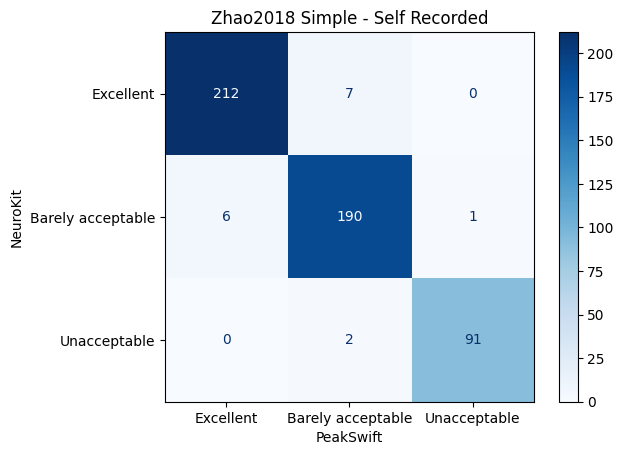

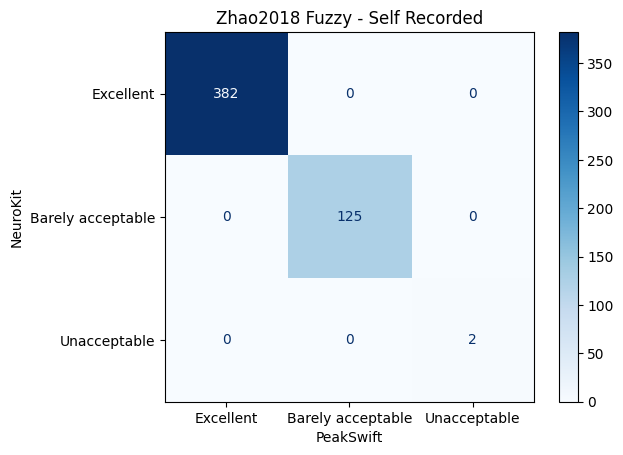

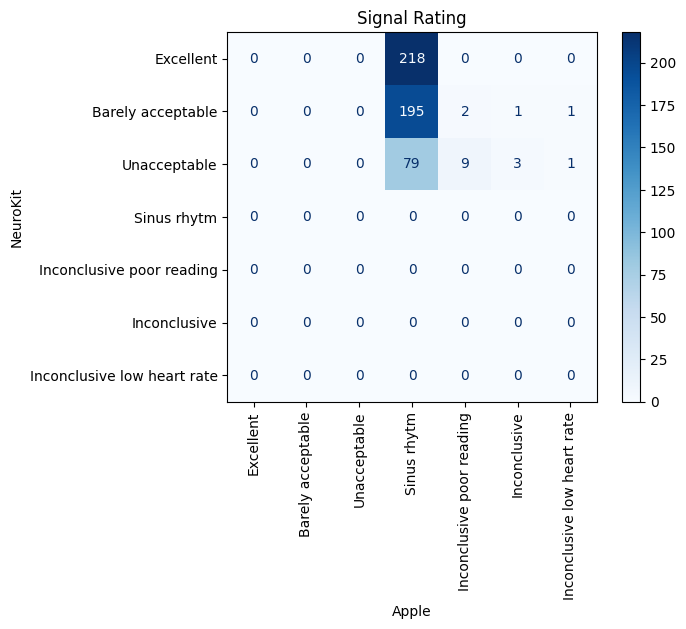

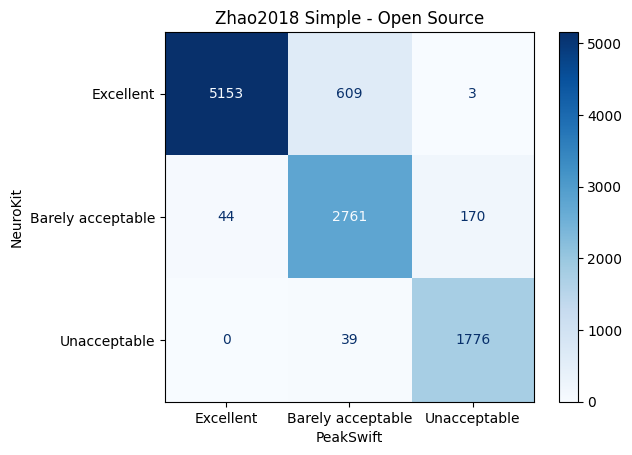

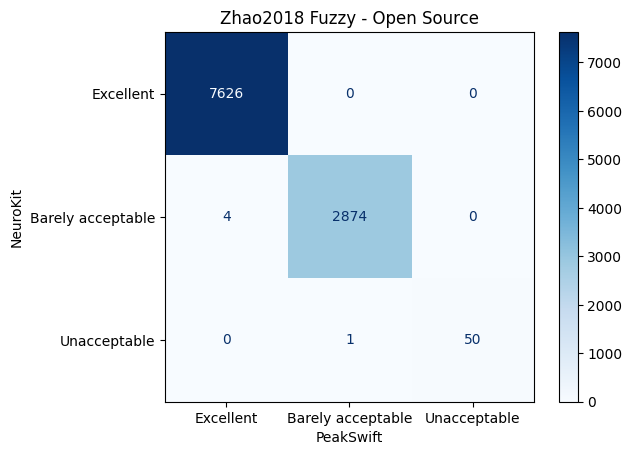

In [23]:
plot_signal_quality(sq, "Self Recorded")
plot_signal_quality(sq_os, "Open Source", False)

### R-peak Detection Accuracy

In [58]:
def print_performance_metrics(result_table):
    print(
    'Mean Absolute Error:',
    np.mean(result_table.mean_difference_t0),
    '±',
    np.std(result_table.mean_difference_t0),
    )
    print(
        'Max Error:',
        np.max(result_table.mean_difference_t0),
    )
    print(
        'Cases with Error:',
        len(result_table.mean_difference_t0[result_table.mean_difference_t0 > 0.0]),
    )
    print(
        'Ratio of cases with error:',
        (len(result_table.mean_difference_t0[result_table.mean_difference_t0 > 0.0]) / len(result_table))*100,
        '%',
    )
    
    print(
        'Mean Absolute Error (error tolerance 10):',
        np.mean(result_table.mean_difference_t10),
        '±',
        np.std(result_table.mean_difference_t10),
    )
    
    print(
        'Number of deviating R-peak count:',
        len(result_table[result_table.peak_diff != 0]),
    )
    print(
        'Ratio of cases with error:',
        (len(result_table.mean_difference_mapped_t0[result_table.mean_difference_mapped_t0 > 0.0]) / len(result_table))*100,
        '%',
    )
    print(
        'Mean Absolute Error:',
        np.mean(result_table.mean_difference_mapped_t0),
        '±',
        np.std(result_table.mean_difference_mapped_t0),
    )
    print(
        'Max Error:',
        np.max(result_table.mean_difference_mapped_t0),
    )
    print(
        'ECGs with Error:',
        len(result_table.mean_difference_mapped_t0[result_table.mean_difference_mapped_t0 > 0.0]),
    )
    print(
        'Mean Absolute Error (error tolerance 10):',
        np.mean(result_table.mean_difference_mapped_t10),
        '±',
        np.std(result_table.mean_difference_mapped_t10),
    )
    
    print(
        'Runtime NeuroKit (ms):',
        np.mean(result_table.runtime_neurokit),
        '±',
        np.std(result_table.runtime_neurokit),
    )
    print(
        'Runtime Swift (ms):',
        np.mean(result_table.runtime_swift),
        '±',
        np.std(result_table.runtime_swift),
    )
    print(
        'Runtime Difference (ms):',
        np.mean(result_table.runtime_difference),
        '±',
        np.std(result_table.runtime_difference),
    )
    print(
        'Runtime Difference without Christov (ms):',
        np.mean(result_table[result_table.algorithm != 'christov'].runtime_difference),
        '±',
        np.std(result_table[result_table.algorithm != 'christov'].runtime_difference),
    )

In [59]:
print_performance_metrics(result_table)

Mean Absolute Error: 0.003171951840883707 ± 0.08071190684109533
Max Error: 3.4358974358974357
Cases with Error: 48
Ratio of cases with error: 1.179651019906611 %
Mean Absolute Error (error tolerance 10): 0.0 ± 0.0
Number of deviating R-peak count: 15
Ratio of cases with error: 1.204227082821332 %
Mean Absolute Error: 0.003470396053621924 ± 0.0829487372539662
Max Error: 3.4358974358974357
ECGs with Error: 49
Mean Absolute Error (error tolerance 10): 0.0031881682528231226 ± 0.08291181533469877
Runtime NeuroKit (ms): 23.518025362394926 ± 35.804830335018714
Runtime Swift (ms): 3.133691522241337 ± 4.694793242635367
Runtime Difference (ms): 20.38433384015359 ± 35.11379460103254
Runtime Difference without Christov (ms): 8.281945108795716 ± 15.171084385689815


In [60]:
print_performance_metrics(result_table_os)

Mean Absolute Error: 0.033973883372039396 ± 1.8020603181181225
Max Error: 356.3333333333333
Cases with Error: 1345
Ratio of cases with error: 1.5962686478595758 %
Mean Absolute Error (error tolerance 10): 0.013031413729869995 ± 1.6699590784231455
Number of deviating R-peak count: 647
Ratio of cases with error: 1.6947744454598321 %
Mean Absolute Error: 0.03106208009142161 ± 0.950532173226377
Max Error: 134.61111111111111
ECGs with Error: 1428
Mean Absolute Error (error tolerance 10): 0.02954849652655458 ± 0.9467073400396949
Runtime NeuroKit (ms): 7.651910617857208 ± 10.84002107739411
Runtime Swift (ms): 0.706397566681304 ± 0.9658193758948508
Runtime Difference (ms): 6.9455130511759045 ± 10.635410487301353
Runtime Difference without Christov (ms): 3.2228611784496173 ± 4.214039112904842


In [52]:
result_table.mean_difference_mapped_t0

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
4064    0.0
4065    0.0
4066    0.0
4067    0.0
4068    0.0
Name: mean_difference_mapped_t0, Length: 4069, dtype: float64

In [53]:
def get_detail_information(result_table):
    evaluation_overview = result_table.groupby('algorithm')[
        [
            'mean_difference_mapped_t0', 'mean_difference_t0', 'mean_difference_mapped_t0',
            'runtime_neurokit', 'runtime_swift', 'runtime_difference',
        ]
    ].agg(mean_std)
    evaluation_overview['peak_diff'] = result_table.groupby('algorithm')[['peak_diff']].agg(np.sum)['peak_diff']
    return evaluation_overview

In [54]:
evaluation_overview = get_detail_information(result_table)
evaluation_overview_os = get_detail_information(result_table_os)

In [57]:
evaluation_overview_os

,mean_difference_mapped_t0,mean_difference_t0,mean_difference_mapped_t0,runtime_neurokit,runtime_swift,runtime_difference,peak_diff
algorithm,,,,,,,
christov,0.00035$\pm$0.03032,5e-05$\pm$0.00295,0.00035$\pm$0.03032,34.17485$\pm$2.53796,1.23461$\pm$0.08944,32.94024$\pm$2.54136,1
elgendi,0.13745$\pm$1.65316,0.1282$\pm$1.64578,0.13745$\pm$1.65316,2.39908$\pm$0.26879,0.16035$\pm$0.01316,2.23873$\pm$0.26895,252
engzee,0.00319$\pm$0.15446,0.00328$\pm$0.15672,0.00319$\pm$0.15446,13.66579$\pm$1.08216,0.38904$\pm$0.02926,13.27675$\pm$1.085,133
hamilton,0.04117$\pm$1.22674,0.01869$\pm$0.78267,0.04117$\pm$1.22674,3.42745$\pm$0.59563,0.11524$\pm$0.01131,3.31221$\pm$0.59041,37
kalidas,0.0$\pm$0.0,0.0$\pm$0.0,0.0$\pm$0.0,0.75261$\pm$0.12868,0.30112$\pm$0.04149,0.45149$\pm$0.13489,0
nabian,0.0$\pm$0.0,0.0$\pm$0.0,0.0$\pm$0.0,5.07603$\pm$0.52734,3.08186$\pm$0.2217,1.99417$\pm$0.57121,0
neurokit,0.03783$\pm$1.34656,0.10232$\pm$4.68665,0.03783$\pm$1.34656,1.11518$\pm$0.22244,0.21892$\pm$0.01778,0.89626$\pm$0.22185,246
pantompkins,0.02804$\pm$1.05936,0.02172$\pm$0.96909,0.02804$\pm$1.05936,0.70625$\pm$0.11356,0.14459$\pm$0.01361,0.56166$\pm$0.11131,18


In [28]:
evaluation_overview

,mean_difference_t0,mean_difference_mapped_t0,runtime_neurokit,runtime_swift,runtime_difference,peak_diff
algorithm,,,,,,
christov,0.0$\pm$0.0,0.0$\pm$0.0,109.45303$\pm$6.00442,5.31194$\pm$2.17693,104.14108$\pm$6.54414,0
elgendi,0.01926$\pm$0.20385,0.01922$\pm$0.20365,6.08655$\pm$0.10209,0.76832$\pm$0.71699,5.31823$\pm$0.72545,1
engzee,0.0$\pm$0.0,0.0$\pm$0.0,45.46707$\pm$1.21512,1.18383$\pm$0.66178,44.28324$\pm$1.37672,2
hamilton,0.0$\pm$0.0,0.00249$\pm$0.05616,5.86612$\pm$0.15934,0.51205$\pm$0.32989,5.35407$\pm$0.36538,1
kalidas,0.0$\pm$0.0,0.0$\pm$0.0,1.11296$\pm$0.56765,1.59855$\pm$0.90346,-0.48559$\pm$1.07185,0
nabian,0.0$\pm$0.0,0.0$\pm$0.0,15.80138$\pm$0.23621,13.90655$\pm$4.38812,1.89483$\pm$4.38844,0
neurokit,0.00616$\pm$0.10139,0.00603$\pm$0.1003,1.67546$\pm$0.07767,1.11451$\pm$0.75424,0.56095$\pm$0.75798,12
pantompkins,0.0$\pm$0.0,0.0$\pm$0.0,0.80559$\pm$0.03663,0.66228$\pm$0.41512,0.14331$\pm$0.41509,0


In [29]:
evaluation_overview_os

,mean_difference_t0,mean_difference_mapped_t0,runtime_neurokit,runtime_swift,runtime_difference,peak_diff
algorithm,,,,,,
christov,5e-05$\pm$0.00295,0.00035$\pm$0.03032,33.78999$\pm$1.09764,1.23461$\pm$0.08944,32.55538$\pm$1.1074,1
elgendi,0.1282$\pm$1.64578,0.13745$\pm$1.65316,2.35242$\pm$0.04557,0.16035$\pm$0.01316,2.19207$\pm$0.04693,252
engzee,0.00328$\pm$0.15672,0.00319$\pm$0.15446,13.47243$\pm$0.46551,0.38904$\pm$0.02926,13.08339$\pm$0.47259,133
hamilton,0.01869$\pm$0.78267,0.04117$\pm$1.22674,3.36047$\pm$0.47976,0.11524$\pm$0.01131,3.24523$\pm$0.47343,37
kalidas,0.0$\pm$0.0,0.0$\pm$0.0,0.72179$\pm$0.03478,0.30112$\pm$0.04149,0.42067$\pm$0.0532,0
nabian,0.0$\pm$0.0,0.0$\pm$0.0,5.02051$\pm$0.07877,3.08186$\pm$0.2217,1.93865$\pm$0.23021,0
neurokit,0.10232$\pm$4.68665,0.03783$\pm$1.34656,1.07155$\pm$0.05783,0.21892$\pm$0.01778,0.85263$\pm$0.05658,246
pantompkins,0.02172$\pm$0.96909,0.02804$\pm$1.05936,0.6775$\pm$0.05662,0.14459$\pm$0.01361,0.53291$\pm$0.05303,18


### Beats per Minute Accuracy
Assessed in a comparison towards FDA approved Apple's BPM rating.

In [29]:
print(
    'Difference to Apple BPM (simple):',
    np.mean(result_table.bpm_difference_simple),
    '±',
    np.std(result_table.bpm_difference_simple),
)

print(
    'Difference to Apple BPM (RR):',
    np.mean(result_table.bpm_difference_rr),
    '±',
    np.std(result_table.bpm_difference_rr),
)

print(
    'BPM Difference without Christov (simple):',
    np.mean(result_table[result_table.algorithm != 'christov'].bpm_difference_simple),
    '±',
    np.std(result_table[result_table.algorithm != 'christov'].bpm_difference_simple),
)

print(
    'BPM Difference without Christov (rr):',
    np.mean(result_table[result_table.algorithm != 'christov'].bpm_difference_rr),
    '±',
    np.std(result_table[result_table.algorithm != 'christov'].bpm_difference_rr),
)

Difference to Apple BPM (simple): 9.029245514868519 ± 32.11564229722207
Difference to Apple BPM (RR): 8.58593310479604 ± 33.26413299569645
BPM Difference without Christov (simple): 3.398876404494382 ± 10.922577322534577
BPM Difference without Christov (rr): 2.688436028318112 ± 11.128866454892181


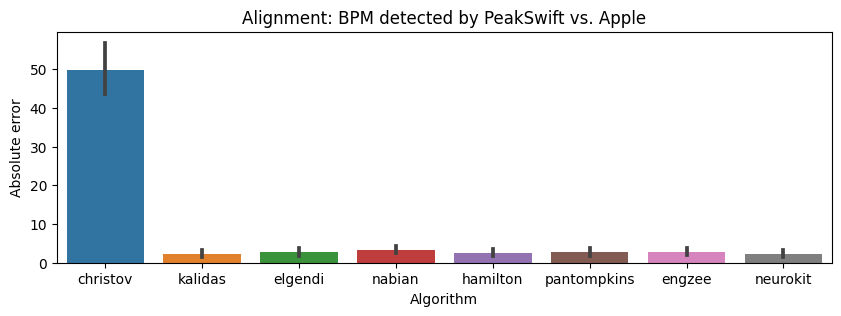

In [30]:
fig = plt.figure(figsize=(10,3))
ax = sns.barplot(data=result_table, x="algorithm", y="bpm_difference_rr")
ax.set(xlabel='Algorithm', ylabel='Absolute error')
ax.set_title('Alignment: BPM detected by PeakSwift vs. Apple')
plt.show()
fig.savefig('./results/comparisonBPM.png', bbox_inches='tight', dpi=300)
plt.close()

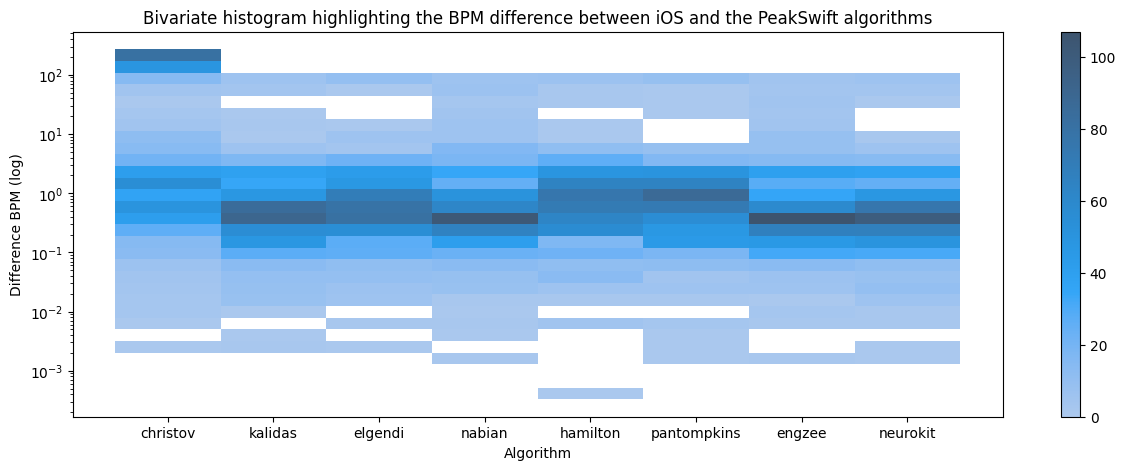

In [31]:
fig = plt.figure(figsize=(15,5))
ax = sns.histplot(
    result_table, x="algorithm", y="bpm_difference_rr",
    bins=30, discrete=(True, False), log_scale=(False, True),
    cbar=True,
)
ax.set(xlabel='Algorithm', ylabel='Difference BPM (log)')
ax.set_title("Bivariate histogram highlighting the BPM difference between iOS and the PeakSwift algorithms")
#Comparison of iOS and PeakSwift's algorithms for calculating the BPM.
plt.show()
fig.savefig('./results/histogramBPM.png', dpi=300, bbox_inches='tight')
plt.close()

### Computational Runtime

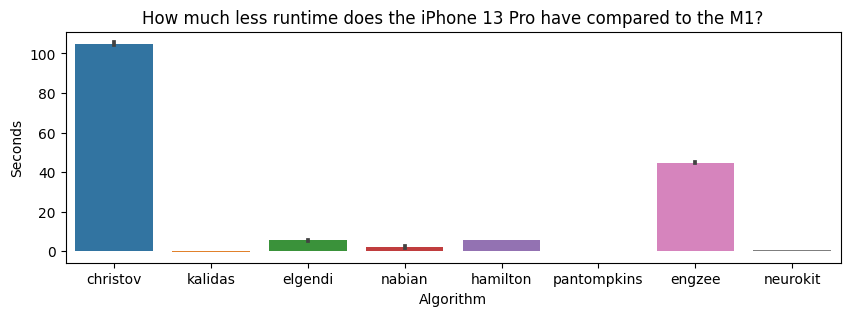

In [32]:
fig = plt.figure(figsize=(10,3))
ax = sns.barplot(data=result_table, x="algorithm", y="runtime_difference")
ax.set(xlabel='Algorithm', ylabel='Seconds')
ax.set_title('How much less runtime does the iPhone 13 Pro have compared to the M1?')
plt.show()
fig.savefig('./results/comparisonRuntime.png', bbox_inches='tight', dpi=300)
plt.close()

In [59]:
print('Self Recorded: How much faster on average is PeakSwift in Comparison to NeuroKit:', np.round(np.mean(result_table.swift_faster),2))
print('Open Source: How much faster on average is PeakSwift in Comparison to NeuroKit:', np.round(np.mean(result_table_os.swift_faster),2))
print('Combined: How much faster on average is PeakSwift in Comparison to NeuroKit:', np.round(np.mean(pd.concat([result_table.swift_faster, result_table_os.swift_faster])),2))

Self Recorded: How much faster on average is PeakSwift in Comparison to NeuroKit: 13.05
Open Source: How much faster on average is PeakSwift in Comparison to NeuroKit: 14.96
Combined: How much faster on average is PeakSwift in Comparison to NeuroKit: 14.88


In [35]:
result_table.groupby('algorithm')[['swift_faster']].agg(np.mean)

,swift_faster
algorithm,
christov,23.709361
elgendi,10.096247
engzee,49.373384
hamilton,15.741985
kalidas,0.896178
nabian,1.222869
neurokit,1.985063
pantompkins,1.569326


In [36]:
result_table_os.groupby('algorithm')[['swift_faster']].agg(np.mean)

,swift_faster
algorithm,
christov,27.525108
elgendi,14.769704
engzee,34.850876
hamilton,29.209571
kalidas,2.419273
nabian,1.637756
neurokit,4.923015
pantompkins,4.713927


### Real-Time Capabilities

In [37]:
result_table.groupby(['algorithm', 'real_time_capabilities_bool'])['id'].count()

algorithm    real_time_capabilities_bool
christov     True                           509
elgendi      True                           509
engzee       True                           506
hamilton     True                           509
kalidas      True                           509
nabian       True                           509
neurokit     True                           509
pantompkins  True                           509
Name: id, dtype: int64

In [38]:
result_table_os.groupby(['algorithm', 'real_time_capabilities_bool'])['id'].count()

algorithm    real_time_capabilities_bool
christov     True                           10555
elgendi      True                           10555
engzee       True                           10375
hamilton     True                           10555
kalidas      True                           10555
nabian       True                           10555
neurokit     True                           10554
pantompkins  True                           10555
Name: id, dtype: int64

## F1 scores, Recall, Precision

In [42]:
result_table.groupby(['algorithm'])

In [33]:
def calculcate_precision(result_table):
    return result_table['tp'] / (result_table['tp'] + result_table['fp'])

def calculcate_recall(result_table):
    return result_table['tp'] / (result_table['tp'] + result_table['fn'])

def calculcate_f1(result_table):
    return 2 * result_table['precision'] * result_table['recall']  / (result_table['precision'] + result_table['recall'])

In [34]:
def calculate_precision_recall_per_algorihtm(results):
    return calculate_precision_recall(results.groupby(['algorithm']))

In [35]:
def calculate_precision_recall(results):
    result_with_scores = results[['tp', 'fp', 'fn']].sum()#.agg({'tp':'sum','fp':'sum', 'fn': 'sum'})
    result_with_scores['precision'] = calculcate_precision(result_with_scores)
    result_with_scores['recall'] = calculcate_recall(result_with_scores)
    result_with_scores['f1'] = calculcate_f1(result_with_scores)
    return result_with_scores

In [41]:
res = calculate_precision_recall(result_table)
res_os = calculate_precision_recall(result_table_os)
print('Self recorded -', 'F1 (Total):', np.round(res['f1'], 4), 'Precision (Total):', np.round(res['precision'], 4), 'Recall (Total):', np.round(res['recall'], 4))
print('Open source -', 'F1 (Total):', np.round(res_os['f1'], 4), 'Precision (Total):', np.round(res_os['precision'], 4), 'Recall (Total):', np.round(res_os['recall'], 4))

Self recorded - F1 (Total): 0.9996 Precision (Total): 0.9997 Recall (Total): 0.9996
Open source - F1 (Total): 0.9982 Precision (Total): 0.9983 Recall (Total): 0.9982


In [49]:
np.round(calculate_precision_recall_per_algorihtm(result_table),4)

,tp,fp,fn,precision,recall,f1
algorithm,,,,,,
christov,30694,0,0,1.0000,1.0000,1.0000
elgendi,19132,18,17,0.9991,0.9991,0.9991
engzee,17980,1,1,0.9999,0.9999,0.9999
hamilton,19143,1,2,0.9999,0.9999,0.9999
kalidas,18973,0,0,1.0000,1.0000,1.0000
nabian,18306,0,0,1.0000,1.0000,1.0000
neurokit,18844,34,40,0.9982,0.9979,0.9980
pantompkins,19199,0,0,1.0000,1.0000,1.0000


In [51]:
np.round(calculate_precision_recall_per_algorihtm(result_table_os), 4)

,tp,fp,fn,precision,recall,f1
algorithm,,,,,,
christov,166902,7,8,1.0000,1.0000,1.0000
elgendi,146260,498,508,0.9966,0.9965,0.9966
engzee,106029,78,67,0.9993,0.9994,0.9993
hamilton,169295,215,192,0.9987,0.9989,0.9988
kalidas,151700,0,0,1.0000,1.0000,1.0000
nabian,120967,0,0,1.0000,1.0000,1.0000
neurokit,139936,1084,1236,0.9923,0.9912,0.9918
pantompkins,158034,114,122,0.9993,0.9992,0.9993
